In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
from torchvision.transforms import v2 as T
torchvision.disable_beta_transforms_warning()
import torch

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3))
        transforms.append(T.GaussianBlur(kernel_size=5, sigma=(0.01, 2.0)))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [4]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = AppleDataset('../Apple/detection/train/', get_transform(train=True))
dataset_test = AppleDataset('../Apple/detection/train/', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-70:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [5]:
# let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/25]  eta: 0:07:51  lr: 0.000213  loss: 4.6668 (4.6668)  loss_classifier: 0.6567 (0.6567)  loss_box_reg: 0.6828 (0.6828)  loss_mask: 1.2836 (1.2836)  loss_objectness: 1.8513 (1.8513)  loss_rpn_box_reg: 0.1923 (0.1923)  time: 18.8788  data: 0.4593
Epoch: [0]  [10/25]  eta: 0:04:50  lr: 0.002294  loss: 2.8036 (3.0639)  loss_classifier: 0.5055 (0.4975)  loss_box_reg: 0.5300 (0.5318)  loss_mask: 0.7401 (0.7983)  loss_objectness: 0.8034 (1.0531)  loss_rpn_box_reg: 0.1844 (0.1831)  time: 19.3726  data: 0.5475
Epoch: [0]  [20/25]  eta: 0:01:38  lr: 0.004376  loss: 1.9091 (2.4659)  loss_classifier: 0.3483 (0.4228)  loss_box_reg: 0.4873 (0.5014)  loss_mask: 0.4344 (0.6166)  loss_objectness: 0.4492 (0.7435)  loss_rpn_box_reg: 0.1596 (0.1816)  time: 19.6701  data: 0.5586
Epoch: [0]  [24/25]  eta: 0:00:19  lr: 0.005000  loss: 1.8252 (2.3397)  loss_classifier: 0.3386 (0.4063)  loss_box_reg: 0.4919 (0.5025)  loss_mask: 0.4091 (0.5762)  loss_objectness: 0.4017 (0.6756)  loss_rpn_box_re

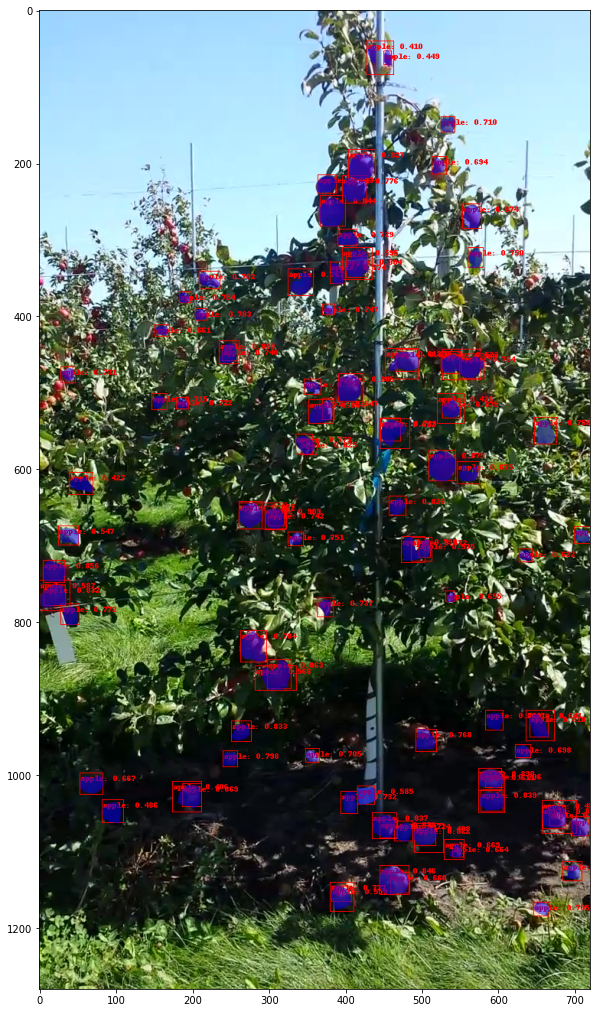

In [55]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("../Apple/detection/train/images/20150921_131833_image186.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"apple: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(18, 18))
plt.imshow(output_image.permute(1, 2, 0))

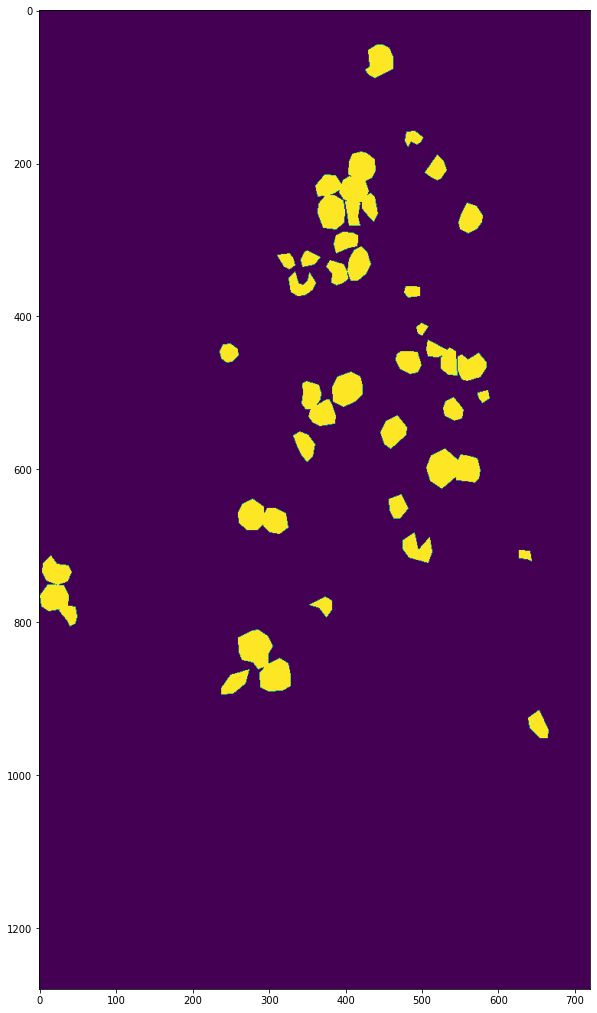

In [56]:
mask = read_image("../Apple/detection/train/masks/20150921_131833_image186.png")
plt.figure(figsize=(18, 18))
plt.imshow(mask[0] > 0)

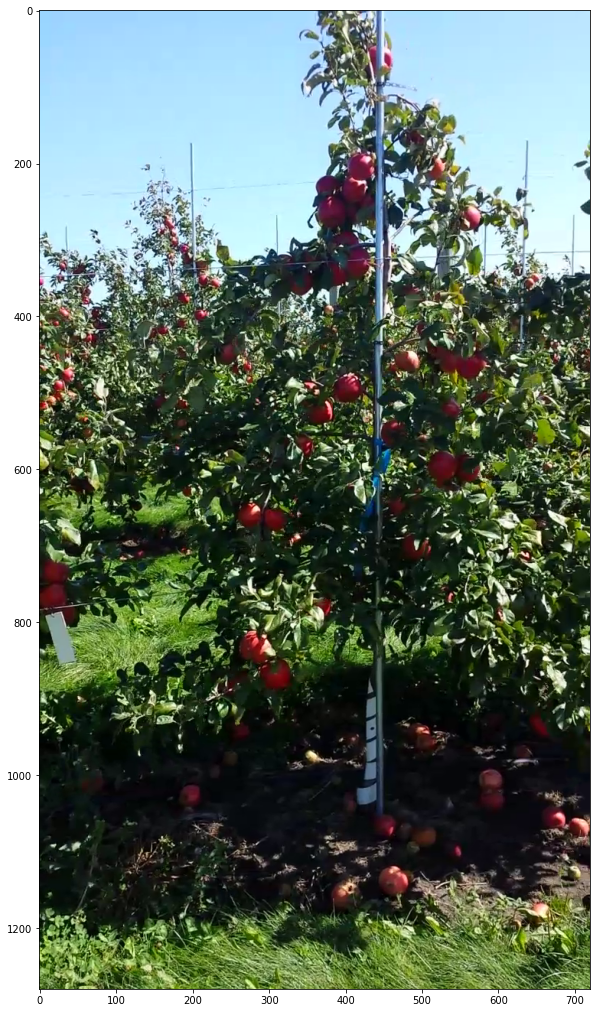

In [57]:
plt.figure(figsize=(18, 18))
plt.imshow(image.permute(1,2,0))

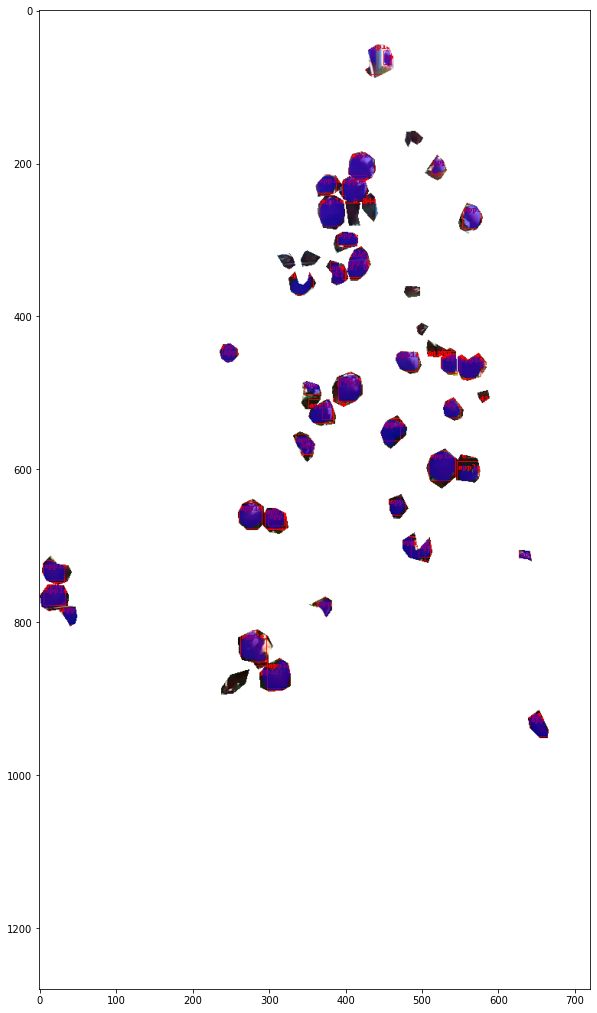

In [59]:
plt.figure(figsize=(18, 18))
plt.imshow((torch.cat([output_image, 255*(mask>0)])).permute(1,2,0))